### Build a timeseries forecast of New Cases

In [110]:
import pandas as pd
import numpy as np
import urllib.request # to request URLs and get the HTML from it
import requests
import string
import matplotlib.pyplot as plt
import schedule
import time

In [111]:
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [112]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


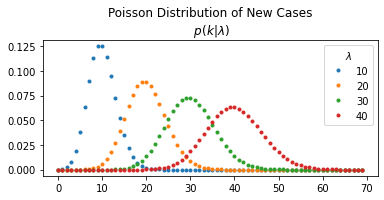

In [113]:
fig, ax = plt.subplots(figsize=(6,2.5))

ax.set(title='Poisson Distribution of New Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas)

### Possion distribution is described as a discrete probability distribution of the number of events occurring in a given time period, given the average number of times the event occurs over that time period.

### Poisson distribution explains that for any k cases, it is a high likelihood that we will get that many cases, plus or minus due to some variation. 

### However, for this case, we do know what $k$ cases but we need to know wha the value for $\lambda$. To do this, we make $k$ constant to see the varying $\lambda$ levels, which is called the likelihood function.

<AxesSubplot:title={'center':'Likelihood $P\\left(k_t=20|\\lambda\\right)$'}, xlabel='$\\lambda$'>

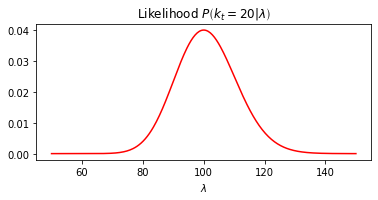

In [114]:
k = 100

lam = np.linspace(50, 150, 300)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=20|\lambda\right)$', figsize=(6,2.5), color='red')

Text(0.5, 0, '$R_t$')

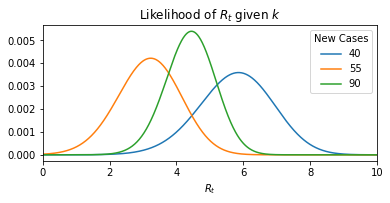

In [115]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10),
    figsize=(6,2.5)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$')

### In plot above you can see that for each day we have independent guesses for $R_t$. The goal is to combine this information wit hthe current day. To do this, we use Bayes Theorem.

### Bayes Theorem is a mathematical formula that helps to determine conditional probability. Conditional probability is the likelihood of an outcome occurring, based on a previous outcome occurring.

Text(0.5, 0, '$R_t$')

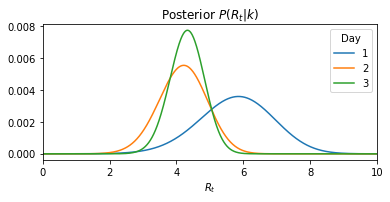

In [116]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10),
    figsize=(6,2.5)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$')

In [117]:
# Help us answer the question "What is the most likely value of $R_t$ each day?"
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
dtype: float64

In [73]:
# We can also obtain the highest density of $R_t$ 

def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors, debug=True)
hdi.tail()

,Low_90,High_90
Day,,
1,3.89,7.55
2,2.96,5.33
3,3.42,5.12


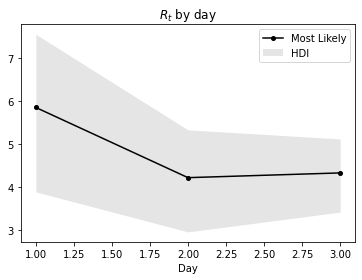

In [74]:
#Plot the most likely values of $R_t$
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend()

In [80]:
url = 'https://data.ontario.ca/dataset/f4f86e54-872d-43f8-8a86-3892fd3cb5e6/resource/ed270bb8-340b-41f9-a7c6-e8ef587e6d11/download/covidtestin'
ontario = pd.read_csv(url,
                     usecols=['Reported Date', 'Total Cases'],
                     parse_dates=['Reported Date'],
                     index_col=['Reported Date'],
                     squeeze=True).sort_index()

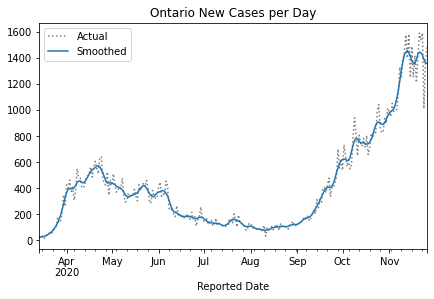

In [81]:
def prepare_cases(cases, cutoff=25):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = ontario

original, smoothed = prepare_cases(cases)

original.plot(title=f"Ontario New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

## Running the Algorithm

### The original approach simply selects yesterday's posterior as today's prior. While intuitive, doing so doesn't allow for our belief that the value of $R_t$ has likely changed from yesterday. To allow for that change, we apply Gaussian noise to the prior distribution with some standard deviation $\sigma$. The higher $\sigma$ the more noise and the more we will expect the value of $R_t$ to drift each day. Interestingly, applying noise on noise iteratively means that there will be a natural decay of distant posteriors. This approach has a similar effect of windowing, but is more robust and doesn't arbitrarily forget posteriors after a certain time like my previous approach. Specifically, windowing computed a fixed $R_t$ at each time $t$ that explained the surrounding $w$ days of cases, while the new approach computes a series of $R_t$ values that explains all the cases, assuming that $R_t$ fluctuates by about $\sigma$ each day.

### This clearly shows us that $R_t$ changes and the highest denisty value narrows as we become more sure about $R_t$.

In [83]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)


Text(0.5, 0, '$R_t$')

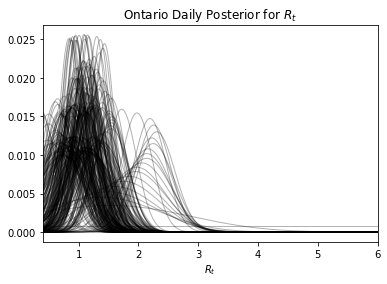

In [84]:
ax = posteriors.plot(title=f'Ontario Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$')

In [85]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result1 = result
result1.tail()

,ML,Low_90,High_90
Reported Date,,,
2020-11-22,1.01,0.72,1.24
2020-11-23,0.94,0.66,1.18
2020-11-24,0.86,0.57,1.10
2020-11-25,0.87,0.58,1.11
2020-11-26,0.95,0.66,1.19


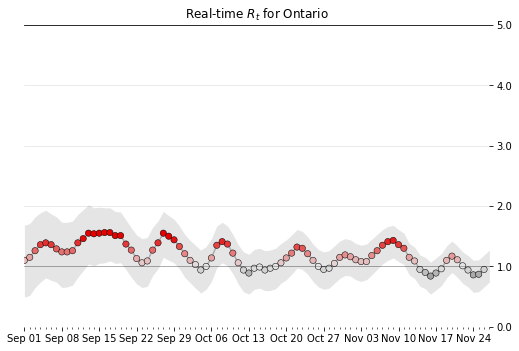

In [86]:
def plot_rt(result1, ax):
    
    ax.set_title("Ontario")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result1['ML'].index.get_level_values('Reported Date')
    values = result1['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result1['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result1['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-09-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25)
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-09-01'), result1.index.get_level_values('Reported Date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result1, ax)
ax.set_title(f'Real-time $R_t$ for Ontario')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### If the R-value is above one then the number of cumulative cases takes off, but if it is below one then eventually the outbreak stops. The further below one, the faster that happens.